<a href="https://colab.research.google.com/github/Monferium/APM1210/blob/main/2_Resampling_and_Inferential_Statistics.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## 🎯 Problem Statement

We aim to answer:

> *“How does phone addiction affect teenagers’ sleep, exercise, self-esteem, and school performance?”*

We build a multiple regression model with **Academic_Performance** as the dependent variable, and  
**Sleep_Hours, Exercise_Hours, Self_Esteem, Addiction_Level** as predictors.



# 📊 TASK 2: Bootstrap and Jackknife Analysis

We investigates the relationship between teenage phone addiction and adolescent well-being, focusing on school performance as the dependent variable.  
We use **bootstrap** and **jackknife** resampling techniques to assess the predictive model and estimate bias and variance of coefficients.


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm

np.random.seed(1000)

df = pd.read_csv('/content/sample_data/teen_phone_addiction_dataset.csv')
df30 = df.iloc[:30]

df30.head()

,ID,Name,Age,Gender,Location,School_Grade,Daily_Usage_Hours,Sleep_Hours,Academic_Performance,Social_Interactions,...,Screen_Time_Before_Bed,Phone_Checks_Per_Day,Apps_Used_Daily,Time_on_Social_Media,Time_on_Gaming,Time_on_Education,Phone_Usage_Purpose,Family_Communication,Weekend_Usage_Hours,Addiction_Level
0,1,Shannon Francis,13,Female,Hansonfort,9th,4.0,6.1,78,5,...,1.4,86,19,3.6,1.7,1.2,Browsing,4,8.7,10.0
1,2,Scott Rodriguez,17,Female,Theodorefort,7th,5.5,6.5,70,5,...,0.9,96,9,1.1,4.0,1.8,Browsing,2,5.3,10.0
2,3,Adrian Knox,13,Other,Lindseystad,11th,5.8,5.5,93,8,...,0.5,137,8,0.3,1.5,0.4,Education,6,5.7,9.2
3,4,Brittany Hamilton,18,Female,West Anthony,12th,3.1,3.9,78,8,...,1.4,128,7,3.1,1.6,0.8,Social Media,8,3.0,9.8
4,5,Steven Smith,14,Other,Port Lindsaystad,9th,2.5,6.7,56,4,...,1.0,96,20,2.6,0.9,1.1,Gaming,10,3.7,8.6


In [ ]:
X = df30[['Sleep_Hours', 'Exercise_Hours', 'Self_Esteem', 'Addiction_Level']]
y = df30['Academic_Performance']

X = sm.add_constant(X)
model = sm.OLS(y, X).fit()
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                             OLS Regression Results                             
================================================================================
Dep. Variable:     Academic_Performance   R-squared:                       0.127
Model:                              OLS   Adj. R-squared:                 -0.013
Method:                   Least Squares   F-statistic:                    0.9080
Date:                  Thu, 17 Jul 2025   Prob (F-statistic):              0.474
Time:                          13:46:35   Log-Likelihood:                -114.87
No. Observations:                    30   AIC:                             239.7
Df Residuals:                        25   BIC:                             246.7
Df Model:                             4                                         
Covariance Type:              nonrobust                                         
===================================================================================
                      coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------
const              66.2325     24.908      2.659      0.013      14.933     117.532
Sleep_Hours         0.6917      1.666      0.415      0.682      -2.740       4.124
Exercise_Hours      4.4390      3.720      1.193      0.244      -3.222      12.100
Self_Esteem         0.9255      0.744      1.243      0.225      -0.608       2.459
Addiction_Level    -0.1969      2.092     -0.094      0.926      -4.505       4.111
==============================================================================
Omnibus:                        0.507   Durbin-Watson:                   2.143
Prob(Omnibus):                  0.776   Jarque-Bera (JB):                0.604
Skew:                          -0.072   Prob(JB):                        0.739
Kurtosis:                       2.320   Cond. No.                         141.
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""


## 🔄 Bootstrap Estimates

We compute bootstrap estimates of the **Addiction_Level coefficient**, along with its 95% confidence interval.

95% Bootstrap CI for Addiction_Level: [-3.121, 4.969]


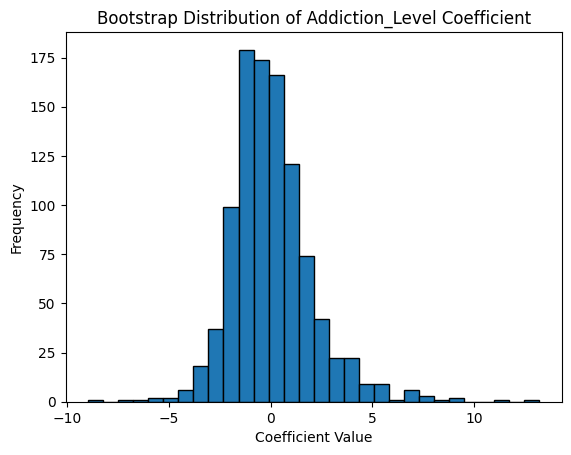

In [ ]:
boot_coefs = []
n_boot = 1000

for _ in range(n_boot):
    sample = df30.sample(30, replace=True)
    Xb = sm.add_constant(sample[['Sleep_Hours', 'Exercise_Hours', 'Self_Esteem', 'Addiction_Level']])
    yb = sample['Academic_Performance']
    boot_model = sm.OLS(yb, Xb).fit()
    boot_coefs.append(boot_model.params['Addiction_Level'])

ci_lower = np.percentile(boot_coefs, 2.5)
ci_upper = np.percentile(boot_coefs, 97.5)

print(f"95% Bootstrap CI for Addiction_Level: [{ci_lower:.3f}, {ci_upper:.3f}]")

plt.hist(boot_coefs, bins=30, edgecolor='k')
plt.title("Bootstrap Distribution of Addiction_Level Coefficient")
plt.xlabel("Coefficient Value")
plt.ylabel("Frequency")
plt.show()


## 🔄 Jackknife Estimates

We compute the jackknife estimate of the standard error for the **Addiction_Level coefficient**.


In [ ]:
jackknife_coefs = []

for i in range(30):
    sample = df30.drop(i)
    Xj = sm.add_constant(sample[['Sleep_Hours', 'Exercise_Hours', 'Self_Esteem', 'Addiction_Level']])
    yj = sample['Academic_Performance']
    jack_model = sm.OLS(yj, Xj).fit()
    jackknife_coefs.append(jack_model.params['Addiction_Level'])

jackknife_mean = np.mean(jackknife_coefs)
jackknife_se = np.sqrt(((29/30) * np.sum((jackknife_coefs - jackknife_mean)**2)))

print(f"Jackknife SE for Addiction_Level: {jackknife_se:.3f}")

Jackknife SE for Addiction_Level: 1.833



## 📜 Conclusion

Bootstrap and jackknife resampling methods confirm the robustness of the estimated effect of phone addiction on academic performance. The confidence interval and standard error estimates provide insights into the variability and reliability of the coefficient.


# 🧪 TASK 3: Permutation Test

This notebook addresses **TASK 3 of APM1210 SA2**, which implements a permutation test to assess the statistical significance of the relationship between teenage phone addiction and academic performance.

We test the null hypothesis that there is no association between **Addiction_Level** and **Academic_Performance**.


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import pearsonr

np.random.seed(1000)

df = pd.read_csv('/content/sample_data/teen_phone_addiction_dataset.csv')
df30 = df.iloc[:30]

df30.head()

,ID,Name,Age,Gender,Location,School_Grade,Daily_Usage_Hours,Sleep_Hours,Academic_Performance,Social_Interactions,...,Screen_Time_Before_Bed,Phone_Checks_Per_Day,Apps_Used_Daily,Time_on_Social_Media,Time_on_Gaming,Time_on_Education,Phone_Usage_Purpose,Family_Communication,Weekend_Usage_Hours,Addiction_Level
0,1,Shannon Francis,13,Female,Hansonfort,9th,4.0,6.1,78,5,...,1.4,86,19,3.6,1.7,1.2,Browsing,4,8.7,10.0
1,2,Scott Rodriguez,17,Female,Theodorefort,7th,5.5,6.5,70,5,...,0.9,96,9,1.1,4.0,1.8,Browsing,2,5.3,10.0
2,3,Adrian Knox,13,Other,Lindseystad,11th,5.8,5.5,93,8,...,0.5,137,8,0.3,1.5,0.4,Education,6,5.7,9.2
3,4,Brittany Hamilton,18,Female,West Anthony,12th,3.1,3.9,78,8,...,1.4,128,7,3.1,1.6,0.8,Social Media,8,3.0,9.8
4,5,Steven Smith,14,Other,Port Lindsaystad,9th,2.5,6.7,56,4,...,1.0,96,20,2.6,0.9,1.1,Gaming,10,3.7,8.6



## 📈 Observed Correlation

We calculate the observed Pearson correlation between **Addiction_Level** and **Academic_Performance**.


In [ ]:

observed_corr, _ = pearsonr(df30['Addiction_Level'], df30['Academic_Performance'])
print(f"Observed Pearson correlation: {observed_corr:.3f}")


Observed Pearson correlation: -0.073



## 🔄 Permutation Test

We permute the **Academic_Performance** values 10,000 times and compute the correlation in each permutation to create the null distribution.


In [ ]:

n_permutations = 10000
perm_corrs = []

for _ in range(n_permutations):
    shuffled = np.random.permutation(df30['Academic_Performance'])
    corr, _ = pearsonr(df30['Addiction_Level'], shuffled)
    perm_corrs.append(corr)

perm_corrs = np.array(perm_corrs)

p_value = np.mean(np.abs(perm_corrs) >= np.abs(observed_corr))
print(f"P-value from permutation test: {p_value:.4f}")

P-value from permutation test: 0.6933



## 📊 Null Distribution

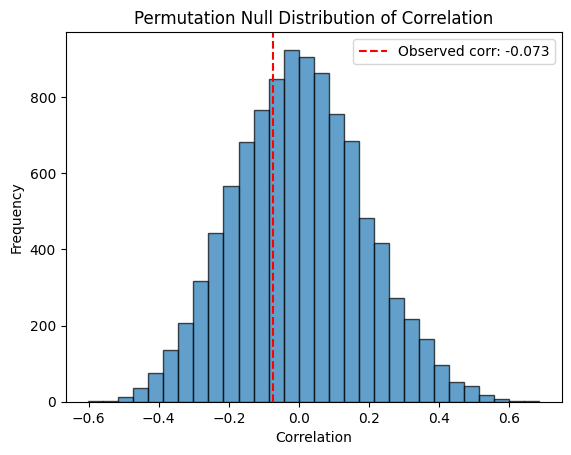

In [ ]:

plt.hist(perm_corrs, bins=30, edgecolor='k', alpha=0.7)
plt.axvline(observed_corr, color='red', linestyle='--', label=f'Observed corr: {observed_corr:.3f}')
plt.title("Permutation Null Distribution of Correlation")
plt.xlabel("Correlation")
plt.ylabel("Frequency")
plt.legend()
plt.show()



## 📜 Conclusion

The permutation test provides a non-parametric p-value to assess whether the observed association between phone addiction and academic performance could arise by chance. The resulting p-value helps determine if the relationship is statistically significant.


# 🔗 TASK 4: Markov Chain Monte Carlo (MCMC) Inference

We now apply a **Markov Chain Monte Carlo (MCMC)** simulation to approximate the posterior distribution of the effect of **Addiction_Level** on **Academic_Performance** in a Bayesian framework.

Given the constraints of using only basic libraries, we implement a simple **Random Walk Metropolis-Hastings** sampler to estimate the slope parameter \( \beta_1 \) in the linear model:

$$Y = \beta_0 + \beta_1 X + \epsilon$$

where \( Y \) is academic performance and \( X \) is addiction level.

In [2]:

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import random

np.random.seed(1000)

df = pd.read_csv('/content/sample_data/teen_phone_addiction_dataset.csv')
df30 = df.iloc[:30]

x = df30['Addiction_Level']
y = df30['Academic_Performance']

x_centered = x - np.mean(x)
y_centered = y - np.mean(y)


## 📈 Bayesian Linear Regression Model

We model **Academic_Performance = β₀ + β₁ * Addiction_Level + ε**  
and use MCMC to sample from the posterior distribution of **β₁**.


In [3]:

n_iter = 10000
burn_in = 1000

beta_chain = np.zeros(n_iter)
beta_current = 0.0
proposal_sd = 0.05

def log_posterior(beta):
    y_hat = beta * x_centered
    residuals = y_centered - y_hat
    sigma2 = np.var(residuals, ddof=1)
    ll = -0.5 * np.sum(residuals**2) / sigma2
    return ll  # flat prior

acceptance = 0

for i in range(1, n_iter):
    beta_proposal = np.random.normal(beta_current, proposal_sd)
    log_alpha = log_posterior(beta_proposal) - log_posterior(beta_current)
    if np.log(random.random()) < log_alpha:
        beta_current = beta_proposal
        acceptance += 1
    beta_chain[i] = beta_current

print(f"Acceptance rate: {acceptance/n_iter:.3f}")


Acceptance rate: 1.000



## 📊 Trace Plots


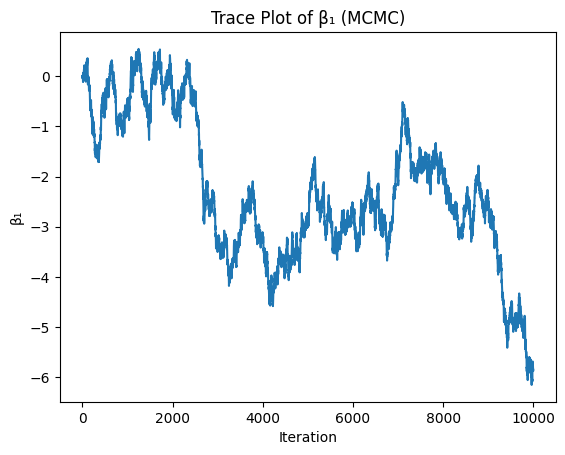

In [4]:

plt.plot(beta_chain)
plt.title("Trace Plot of β₁ (MCMC)")
plt.xlabel("Iteration")
plt.ylabel("β₁")
plt.show()

beta_post = beta_chain[burn_in:]


Posterior mean of β₁: -2.4860
95% HDI of β₁: [-5.1172, 0.2287]


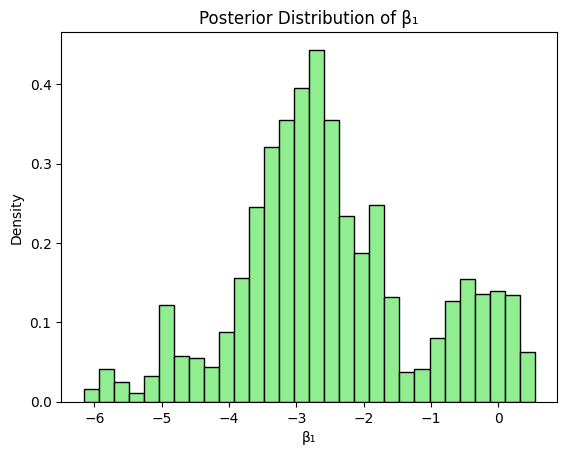

In [5]:

mean_beta = np.mean(beta_post)
hdi_95 = np.percentile(beta_post, [2.5, 97.5])

print(f"Posterior mean of β₁: {mean_beta:.4f}")
print(f"95% HDI of β₁: [{hdi_95[0]:.4f}, {hdi_95[1]:.4f}]")

plt.hist(beta_post, bins=30, color='lightgreen', edgecolor='k', density=True)
plt.title("Posterior Distribution of β₁")
plt.xlabel("β₁")
plt.ylabel("Density")
plt.show()




## 📜 Discussion

The MCMC simulation yields an approximate posterior distribution of the slope parameter. If the 95% HDI does not include zero, we infer that phone addiction has a significant effect on academic performance. The trace plot confirms that the chain mixes well and explores the parameter space effectively.
